In [14]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

## 1. Знакомство с данными

In [2]:
data = pd.read_csv('houses_train.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3392,20151013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,18295,20151209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,14569,20151209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,14081,20160218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,6725,20150627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


Посмотрим, как данные разделены по районам:

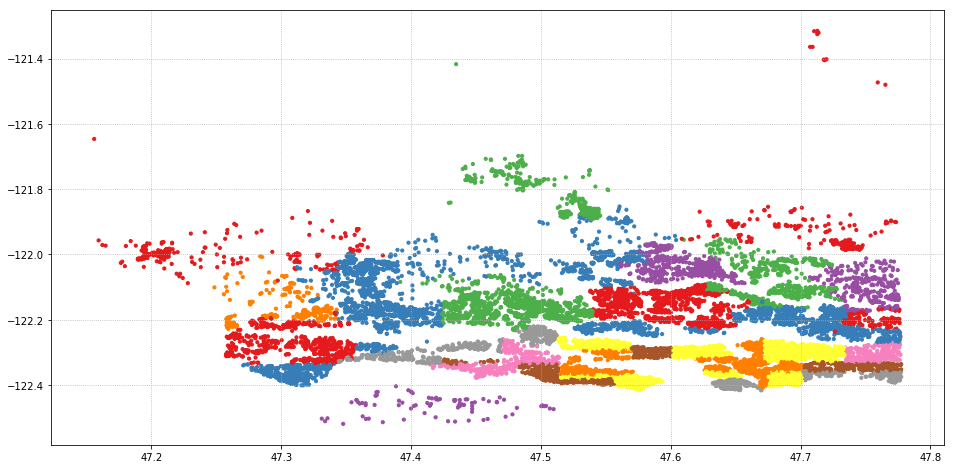

In [4]:
plt.figure(figsize=(16, 8))
plt.scatter(data['lat'], data['long'], c=data['zipcode'], cmap='Set1', s=10)
plt.grid(linestyle=':');

Нарисуем карту, где цвет отражает цену, и увидим самый дорогой район города.

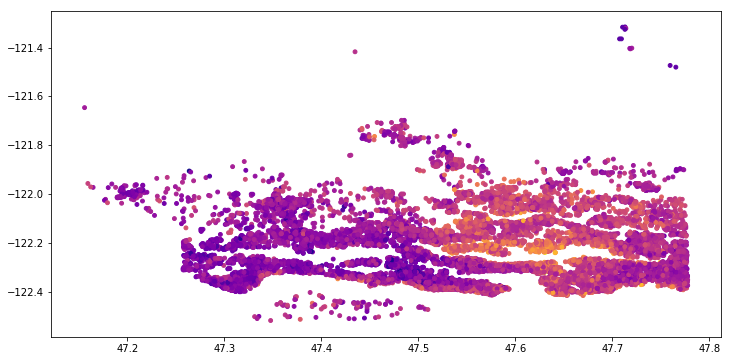

In [5]:
plt.figure(figsize=(12, 6))
plt.scatter(data['lat'], data['long'], c=np.log(data['price']), s=15, cmap='plasma')
max_price = data['price'].idxmax()

`sqft_above` + `sqft_basement` почти везде равно `sqft_living` (с небольшой погрешностью), поэтому столбец `sqft_above` удалим

In [6]:
target = data['price']
print((abs(data['sqft_above'] + data['sqft_basement'] 
       - data['sqft_living']) / data['sqft_living'] 
       < 0.04).all())

True


## 2. Работа с признаками

Преобразование фичей:  
- вместо категориального признака `zipcode` введём два признака - один равный усреднённой цене на все дома с данным `zipcode` (т.е. в данном районе) и другой - то же, только средняя цена за квадратный метр. Сохраним отображение из `zipcode` в средние цены, чтобы потом использовать на тестовой выборке.
- Найдём самый "элитный" район города (по средней цене домов), найдём его центр и посчитаем расстояние от каждого из домов до этого центра.
- С признаками-датами сделаем следующее:
    - заменим дату постройки на возраст дома на момент продажи
    - заменим год реновации на два признака - перестраивался ли дом в принципе (бинарный) и время, прошедшее с реновации на момент продажи (или время с постройки, если `was_renovated`=0)
    - токже добавим отдельно год и месяц, в которые был продан дом

Добавим следующие признаки (поможем модели делить и умножать существующие):
- какой процент площади занимает подвальное помещение
- во сколько раз площадь жилья и участка соседей больше/меньше собственного
- среднюю площадь комнаты
- и, наконец, основная идея: так все такие признаки, как оценка состояния, вид и т.д. влияют на цену квадратного метра, а общая цена дома пропорциональна ей (т.е. маленький хороший дом может стоить так же, как большая развалюха), то логично добавить признаки, умноженные на площадь жилья и площадь участка. Но я не стала ограничиваться логичными (как `grade` и `view`), а умножила все, и это дало неплохой результат. Кроме того, для признаков `condition`, `bedrooms`, `bathrooms`, `floors` и `grade` я добавила их экспоненциальную шкалу. Но потом, увидев в итоговой модели, что их значимость практически нулевая, удалила, и они остались только в произведении с площадью. 

In [7]:
def transform_data(data, 
                   prices_by_zipcode,
                   prices_per_meter_by_zipcode,
                   lat_max, long_max):
    # преобразования
    data['prices_by_zipcode'] = data['zipcode'].map(prices_by_zipcode)
    data['prices_per_meter_by_zipcode'] = data['zipcode'].map(prices_per_meter_by_zipcode)
    data['distance_from_rublevka'] = np.sqrt((data['lat'] - lat_max)**2 + (data['long'] - long_max)**2)
    data = data.drop(['id', 'sqft_above', 'zipcode'], axis=1)

    # даты
    data['age'] = pd.to_datetime(data['date']).dt.year - data['yr_built']
    data['was_renovated'] = (data['yr_renovated'] != 0)
    data.loc[data['yr_renovated'] == 0, 'yr_renovated'] = data['yr_built']
    data['years_from_renovation'] = pd.to_datetime(data['date']).dt.year - data['yr_renovated']
    data['year_sold'] = pd.to_datetime(data['date']).dt.year
    data['month_sold'] = pd.to_datetime(data['date']).dt.month
    data = data.drop(['date', 'yr_built', 'yr_renovated'], axis=1)

    # просто те же признаки, но в качестве показателей степени
    for feature in ['condition', 'bedrooms', 'bathrooms', 'floors']:
        data[feature + '_exp_scale'] = 10.0**(data[feature] - 1)
    data['grade_exp_scale'] = 2.0**(data['grade'] - 1)
    
    # новые признаки
    data['basement_percentage'] = data['sqft_basement'] / data['sqft_living']
    data['compare_to_neighbour_sqft_living'] = data['sqft_living'] / data['sqft_living15']
    data['compare_to_neighbour_sqft_lot'] = data['sqft_lot'] / data['sqft_lot15']
    data['mean_room_sqft'] = data['sqft_living'] / data['bedrooms']
    
    # все признаки, увеличенные пропорционально площади дома
    for feature in ['bedrooms', 'bathrooms', 
                'floors',
                'waterfront', 'view',
                'condition', 'grade',
                'lat', 'long', 'sqft_living15', 'sqft_lot15',
                'prices_by_zipcode', 'prices_per_meter_by_zipcode',
                'distance_from_rublevka',
                'age', 'was_renovated', 'years_from_renovation'] + [
    f + '_exp_scale' for f in ['condition', 'bedrooms', 'bathrooms', 'floors', 'grade']]:
        data[feature + '_dot_sqft_living'] = data[feature] * data['sqft_living']
        data[feature + '_dot_sqft_lot'] = data[feature] * data['sqft_lot']
    data = data.drop([f + '_exp_scale' for f in [
        'condition', 'bedrooms', 'bathrooms', 'floors', 'grade']], axis=1)
    
    return data

В преобразовании данных мы используем расстояние до центра самого дорогого района города. Координаты центра передаются в функцию преобразования (`lat_max`, `long_max`), поэтому сейчас нам необходимо их найти. Для этого сгруппируем цены по признаку `zipcode`, найдём среднее для каждого, из средних возьмём максимум и усредним координаты уже отдельно для него.

In [8]:
prices_by_zipcode = dict(data.groupby(['zipcode']).mean()['price'])
data['price_per_meter'] = data['price'] / data['sqft_living']
prices_per_meter_by_zipcode = dict(data.groupby(['zipcode']).mean()['price_per_meter'])
elite_zipcode = [k for k, v in prices_by_zipcode.items() if v == max(prices_by_zipcode.values())][0]
lat_max, long_max = data.groupby(['zipcode']).mean().loc[elite_zipcode, 'lat'], \
                    data.groupby(['zipcode']).mean().loc[elite_zipcode, 'long']

Нарисуем то что получилось. Элитный район - красный, его центр - оранжевая точка. Как видим, найденное место выделялось уже в изначальной визуализации, так что всё верно. 

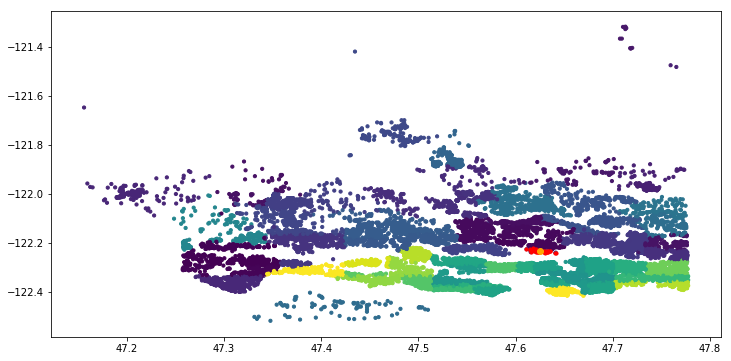

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(data['lat'], data['long'], c=data['zipcode'], s=10)
plt.scatter(data[data['zipcode'] == elite_zipcode]['lat'],
            data[data['zipcode'] == elite_zipcode]['long'],
            c='r', s=10)
plt.scatter(lat_max, long_max, c='orange');

В следующей ячейке преобразуем тестовые данные и уберём из них лишние поля.

In [10]:
data = transform_data(data, 
                   prices_by_zipcode,
                   prices_per_meter_by_zipcode,
                   lat_max, long_max)
data = data.drop(['price_per_meter', 'price'], axis=1)
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,...,condition_exp_scale_dot_sqft_living,condition_exp_scale_dot_sqft_lot,bedrooms_exp_scale_dot_sqft_living,bedrooms_exp_scale_dot_sqft_lot,bathrooms_exp_scale_dot_sqft_living,bathrooms_exp_scale_dot_sqft_lot,floors_exp_scale_dot_sqft_living,floors_exp_scale_dot_sqft_lot,grade_exp_scale_dot_sqft_living,grade_exp_scale_dot_sqft_lot
0,3,1.00,1180,5650,1.0,0,0,3,7,0,...,118000.0,565000.0,118000.0,565000.0,1180.000000,5650.000000,1180.0,5650.0,75520.0,361600.0
1,3,2.25,2570,7242,2.0,0,0,3,7,400,...,257000.0,724200.0,257000.0,724200.0,45701.780838,128782.994875,25700.0,72420.0,164480.0,463488.0
2,4,3.00,1960,5000,1.0,0,0,5,7,910,...,19600000.0,50000000.0,1960000.0,5000000.0,196000.000000,500000.000000,1960.0,5000.0,125440.0,320000.0
3,3,2.00,1680,8080,1.0,0,0,3,8,0,...,168000.0,808000.0,168000.0,808000.0,16800.000000,80800.000000,1680.0,8080.0,215040.0,1034240.0
4,3,2.25,1715,6819,2.0,0,0,3,7,0,...,171500.0,681900.0,171500.0,681900.0,30497.491882,121260.872971,17150.0,68190.0,109760.0,436416.0


In [11]:
print(data.shape)

(15626, 70)


Далее посмотрим, насколько коррелируют наши признаки (здесь ничего неожиданного: сильная корреляция между теми, которые мы домножали на один и тот же коэффициент)

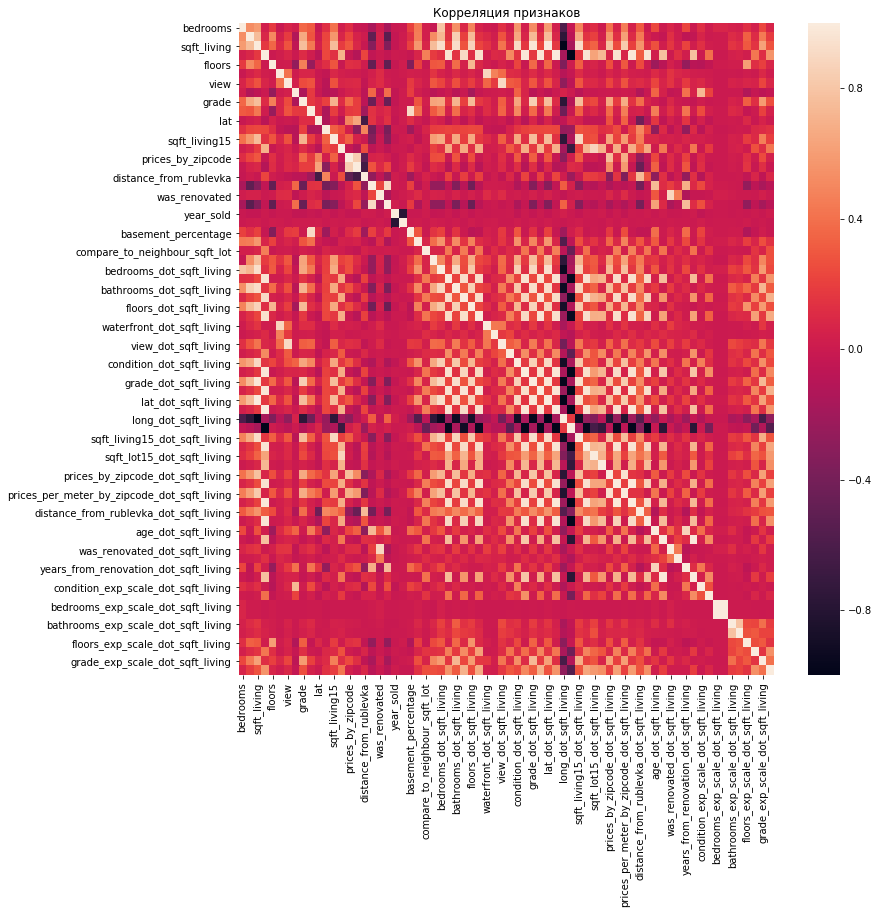

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr()) 
t = plt.title("Корреляция признаков")

## 3. Выбор моделей

Для сравнения качества нам пригодится метрика `MAPE` (хотя оптимизировать её напрямую, конечно, нельзя - для обучения используем просто `MSE`)

In [13]:
def mape_score(y_true, y_predicted):
    return np.mean(np.abs(y_true - y_predicted) / y_true)

С выбором модели вопросов не возникало, ведь известно, что градиентный бустинг - лучший помощник в соревнованиях на каггле. Осталось только подобрать параметры: сделаем это случайным поиском, так как параметров целых 3, и в случае `gridsearch`-а  сетка получится или очень большая, или неточная.

In [15]:
random_search = RandomizedSearchCV(xgb.XGBRegressor(), 
    param_distributions={
    'n_estimators': sps.randint(low=2000, high=6000),
    'learning_rate': [0.01],
    'max_depth': sps.randint(low=4, high=10),
    'subsample': sps.uniform(loc=0.5, scale=0.3),
    },
    n_iter=10,
    cv=3, 
    n_jobs=-1,
    return_train_score=True,
    scoring=make_scorer(mape_score, greater_is_better=False),
    verbose=10
    )
random_search.fit(np.array(data), np.array(target))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 24.8min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 26.2min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 30.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 32.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa6b460e438>, 'learning_rate': [0.01], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa6b460e470>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa6b460e908>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(m

In [26]:
best_params = random_search.best_params_
print(best_params)

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 4958, 'subsample': 0.5095764820380737}


Посмотрим, на каких наборах парамеров получились лучшие результаты. Если бы мы задали какие-то совсем неадекватные границы для случайного поиска, можно было бы таким образом это заметить и улучшить. Но тут всё в порядке:   

In [18]:
result = pd.DataFrame(random_search.cv_results_)[[
    'param_learning_rate', 'param_max_depth',
    'param_n_estimators', 'param_subsample',
    'mean_test_score', 'rank_test_score', 'mean_train_score'
]]
result[result['rank_test_score'] < 10]

,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,rank_test_score,mean_train_score
0,0.01,6,2522,0.72314,-0.119729,5,-0.071424
1,0.01,5,5250,0.633437,-0.119222,4,-0.063938
2,0.01,6,4958,0.509576,-0.118952,1,-0.049089
3,0.01,5,5795,0.665886,-0.118986,2,-0.059500
4,0.01,4,5805,0.56346,-0.120611,9,-0.083192
5,0.01,7,3943,0.589378,-0.119190,3,-0.037588
6,0.01,9,2444,0.639167,-0.120399,7,-0.028256
8,0.01,9,3101,0.60583,-0.120454,8,-0.020214
9,0.01,6,2554,0.595773,-0.120140,6,-0.074183


Теперь обучим с `XGBRegressor` с лучшими параметрами. Можно было бы взять и `random_search.best_estimator_`, но он обучен не на полных данных, а с исключением подмножества для кросс-валидации. А мы боремся за каждую тысячную балла на кагле!

In [21]:
grad_boost = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    n_jobs=-1
)
grad_boost.fit(np.array(data), np.array(target))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=4958, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5095764820380737)

Ещё можно взглянуть на значимость признаков. Если какие-то из них мы добавляли вручную, то можно увидеть, что некоторые из них, вопреки предположениям, не особо помогают (но это не значит, что их обязательно удалять)

In [23]:
sorted(list(zip(grad_boost.feature_importances_, data.columns)))

[(0.0006207382, 'bedrooms'),
 (0.0010073672, 'condition'),
 (0.0011593606, 'floors'),
 (0.0013671934, 'bathrooms'),
 (0.0014149902, 'lat_dot_sqft_lot'),
 (0.001556657, 'long_dot_sqft_lot'),
 (0.0015827516, 'month_sold'),
 (0.0017012606, 'bedrooms_dot_sqft_lot'),
 (0.0017145465, 'sqft_lot15'),
 (0.0017322748, 'sqft_lot15_dot_sqft_living'),
 (0.0017358004, 'prices_by_zipcode_dot_sqft_lot'),
 (0.0017609553, 'compare_to_neighbour_sqft_lot'),
 (0.0017696175, 'sqft_lot15_dot_sqft_lot'),
 (0.001784059, 'sqft_lot'),
 (0.0018463883, 'prices_per_meter_by_zipcode_dot_sqft_lot'),
 (0.0018692205, 'condition_dot_sqft_lot'),
 (0.0019310656, 'grade_dot_sqft_lot'),
 (0.0019577672, 'bedrooms_exp_scale_dot_sqft_lot'),
 (0.0019748379, 'mean_room_sqft'),
 (0.002077991, 'sqft_living15_dot_sqft_lot'),
 (0.002094447, 'age_dot_sqft_lot'),
 (0.0021026565, 'bathrooms_dot_sqft_lot'),
 (0.0021344007, 'long_dot_sqft_living'),
 (0.0024474922, 'floors_exp_scale_dot_sqft_lot'),
 (0.0024577565, 'was_renovated'),
 (0.00

Наконец, сделаем предсказания. Это может показаться очевидным, но тестовые данные мы преобразуем точно так же, как и `data` :)

In [24]:
test_data = pd.read_csv('houses_test.csv')
test_data = transform_data(test_data, 
                   prices_by_zipcode,
                   prices_per_meter_by_zipcode,
                   lat_max, long_max)
assert sum(test_data.columns == data.columns) == len(data.columns)

In [25]:
predicted = grad_boost.predict(np.array(test_data))
test_predictions = pd.DataFrame(predicted)
test_predictions.insert(0, 'index', 1+np.arange(len(test_predictions)))
test_predictions.columns = ['index', 'price']
test_predictions.to_csv(f'answer_{datetime.now():%Y%m%d-%H%M-%S}.csv', index=False)
test_predictions.head()

,index,price
0,1,291629.18750
1,2,906873.81250
2,3,187603.46875
3,4,443859.68750
4,5,283426.06250
